In [3]:
from re import S
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import math
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Carga de datos

In [5]:
df = pd.read_csv('close_normalized_prices_index.csv')
# df['X'] = df['X'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))
df['Y'] = df['Y'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' '))

In [6]:
df['X'] = df['X'].apply(lambda x:np.fromstring(x.replace('[', '').replace(']', '').replace('\n', ' '), sep=' ').reshape(14, 28))

# Division train-test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(np.stack(df.X.to_numpy()).astype(np.float32),
                                                    np.stack(df.Y.to_numpy()).astype(np.float32),
                                                    test_size=0.30,
                                                    random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                    y_test,
                                                    test_size=0.50,
                                                    random_state=42)

# Conversión a tensores

In [8]:
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 14, 28)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 14, 28)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 14, 28)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Dataloaders

In [9]:
# Crear DataLoaders
batch_size = 100
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Modelo

In [11]:
class CNN_LSTM(nn.Module):

  def __init__(self):
    super(CNN_LSTM, self).__init__()
    # Capa Conv1D para extracción de características espaciales
    self.conv1 = nn.Conv1d(in_channels=14, out_channels=64, kernel_size=5, padding=1)
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
    self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=1)

    # Batch normalization
    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(128)
    self.bn3 = nn.BatchNorm1d(256)

    # Max Pool
    self.pool = nn.MaxPool1d(kernel_size=2)

    # Dropout
    self.dropout_layer = nn.Dropout(p=0.15)

    # ReLu
    self.relu = nn.ReLU()

    # Capa LSTM
    self.lstm = nn.LSTM(input_size=256, hidden_size=64, num_layers=3, batch_first=True)

    # Capa Fully Connected
    self.fc1 = nn.Linear(64, 32)  # Predecir 5 valores
    self.fc2 = nn.Linear(32, 16)  # Predecir un solo valor
    self.fc3 = nn.Linear(16, 5)  # Predecir un solo valor

    # Inicialización de pesos
    self._initialize_weights()

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
          nn.init.zeros_(m.bias)

  def forward(self, x):
    # Primer capa completa
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool(x)

    # Segunda capa completa
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Tercera capa completa
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    x = self.pool(x)

    # Reordenar datos
    # Antes batch, channels, seq_length
    x = x.permute(0, 2, 1)
    # Después batch, seq_length, features

    # Capas LSTM
    x, _ = self.lstm(x)

    # Se toma la ultima salida de secuencia, que es la representación de la serie
    x = x[:, -1, :]

    # Capas Fully Connected
    x = self.dropout_layer(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout_layer(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout_layer(x)
    x = self.fc3(x)

    return x

# Función de perdida propia

In [9]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, y_pred, y_true):
        mse = torch.mean(((y_pred - y_true)*100) ** 2)
        return mse

# Train model

Epoch 1/600, Train Loss: 1122.394926, Val Loss: 1031.869322
Epoch 2/600, Train Loss: 1036.525333, Val Loss: 994.772890
Epoch 3/600, Train Loss: 1013.809807, Val Loss: 973.769938
Epoch 4/600, Train Loss: 994.554091, Val Loss: 962.320864
Epoch 5/600, Train Loss: 975.930833, Val Loss: 975.061510
Epoch 6/600, Train Loss: 958.251007, Val Loss: 945.889287
Epoch 7/600, Train Loss: 938.639881, Val Loss: 931.423255
Epoch 8/600, Train Loss: 919.076915, Val Loss: 929.831298
Epoch 9/600, Train Loss: 898.562254, Val Loss: 920.621655
Epoch 10/600, Train Loss: 880.267792, Val Loss: 931.267004
Epoch 11/600, Train Loss: 859.175736, Val Loss: 912.568652
Epoch 12/600, Train Loss: 841.375977, Val Loss: 907.120841
Epoch 13/600, Train Loss: 826.832215, Val Loss: 900.212114
Epoch 14/600, Train Loss: 807.132745, Val Loss: 907.197709
Epoch 15/600, Train Loss: 792.079533, Val Loss: 911.535124
Epoch 16/600, Train Loss: 778.828614, Val Loss: 896.666112
Epoch 17/600, Train Loss: 762.165565, Val Loss: 903.073181
Ep

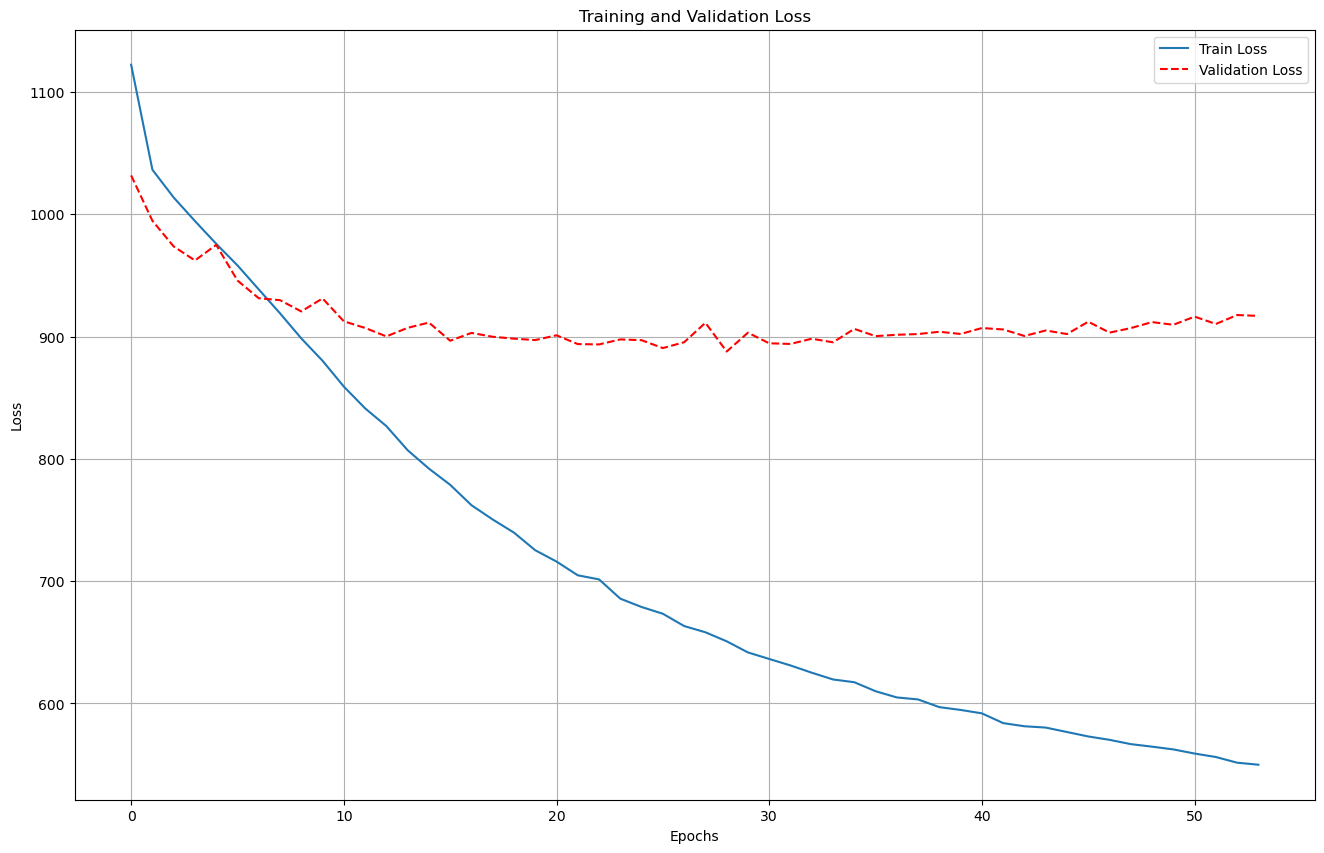

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM().to(device)
criterion = CustomLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 600
# Parámetros de Early Stopping
patience = 25  # Número de épocas sin mejora antes de detener el entrenamiento
min_delta = 0.3  # Diferencia mínima para considerar una mejora
best_val_loss = float("inf")
counter = 0  # Contador de épocas sin mejora

# Listas para almacenar pérdidas
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    train_loss = total_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluación en el conjunto de validación
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_val_pred = model(X_val)
            val_loss = criterion(y_val_pred, y_val)
            total_val_loss += val_loss.item()
    
    val_loss = total_val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    # 📌 Early Stopping Logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        counter = 0  # Reinicia el contador si la validación mejora
        torch.save(model.state_dict(), "best_model.pth")  # Guarda el mejor modelo
    else:
        counter += 1  # Incrementa el contador si no hay mejora
    
    if counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break  # Detiene el entrenamiento

# 📊 Graficar pérdidas
plt.figure(figsize=(16, 10))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss", linestyle = '--', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.grid()
plt.show()

In [ ]:
model.eval()
predictions = []
actuals = []

# Score en test
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Convertir listas en arrays
predictions_test = np.concatenate(predictions).reshape(-1, 5)
actuals_test = np.concatenate(actuals).reshape(-1, 5)

# Score en train
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Convertir listas en arrays
predictions_train = np.concatenate(predictions).reshape(-1, 5)
actuals_train = np.concatenate(actuals).reshape(-1, 5)

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch,  y_batch= X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Convertir listas en arrays
predictions_val = np.concatenate(predictions).reshape(-1, 5)
actuals_val = np.concatenate(actuals).reshape(-1, 5)

ValueError: too many values to unpack (expected 1)

In [14]:
print("Evaluación del modelo:")
print("MAE Train:", np.mean(np.abs(predictions_train - actuals_train)),
      "MAE Val:", np.mean(np.abs(predictions_val - actuals_val)),
      "MAE Test:", np.mean(np.abs(predictions_test - actuals_test)))
print("MSE Train:", np.mean((predictions_train - actuals_train) ** 2),
      "MSE Val:", np.mean((predictions_val - actuals_val) ** 2),
      "MSE Test:", np.mean((predictions_test - actuals_test) ** 2))
print("RMSE Train:", np.sqrt(np.mean((predictions_train - actuals_train) ** 2)),
      "RMSE Val:", np.sqrt(np.mean((predictions_val - actuals_val) ** 2)),
      "RMSE Test:", np.sqrt(np.mean((predictions_test - actuals_test) ** 2)))

Evaluación del modelo:
MAE Train: 0.16583195 MAE Val: 0.17154364 MAE Test: 0.20468485
MSE Train: 0.05502213 MSE Val: 0.060515895 MSE Test: 0.09264943
RMSE Train: 0.23456797 RMSE Val: 0.24599978 RMSE Test: 0.3043837


**V1 eval (20 epochs)**

Evaluación del modelo:

MAE Train: 0.18331179 MAE Test: 0.20078355

MSE Train: 0.07033019 MSE Test: 0.08963985

RMSE Train: 0.26519838 RMSE Test: 0.29939914

**V1 eval (50 epochs)**

Evaluación del modelo:

MAE Train: 0.16892084 MAE Test: 0.20223841

MSE Train: 0.05833414 MSE Test: 0.09049564

RMSE Train: 0.2415246 RMSE Test: 0.30082494

**V1 eval (150 epochs)**

MAE Train: 0.16892084 MAE Test: 0.20223841

MSE Train: 0.05833414 MSE Test: 0.09049564

RMSE Train: 0.2415246 RMSE Test: 0.30082494

# Guardado de modelo

In [ ]:
torch.save(model.state_dict(), "../weights/cnn_lstm_index_v1_weights_3.pth")
torch.save(model, "../models/cnn_lstm_index_v1_model_3.pth")

# Visualización de modelo

In [15]:
from torchviz import make_dot
from IPython.display import Image

In [25]:
model = CNN_LSTM()

# Cargar el estado del modelo guardado
#model.load_state_dict(torch.load("../weights/cnn_lstm_index_v1_weights_3.pth"))

# Mover el modelo al dispositivo adecuado (CPU o GPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [27]:
dot = make_dot(y_pred, params=dict(model.named_parameters()))
# Guardar el gráfico en un archivo
dot.format = 'png'
dot.render('cnn_lstm_model')

'cnn_lstm_model.png'

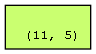

In [28]:
Image(filename='cnn_lstm_model.png')

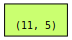

In [26]:
make_dot(y_pred, params=dict(list(model.named_parameters()) + [('input', X_batch)]))

In [29]:
dict(list(model.named_parameters()))

{'conv1.weight': Parameter containing:
 tensor([[[ 0.0991,  0.1113,  0.0316, -0.0127,  0.0051],
          [ 0.1236,  0.0549, -0.0417, -0.0643, -0.0038],
          [-0.0158,  0.0665, -0.1046,  0.0404, -0.1201],
          ...,
          [ 0.0159,  0.1121, -0.0681, -0.1184,  0.1145],
          [ 0.0544, -0.0939,  0.0966,  0.0121,  0.1014],
          [ 0.0686, -0.0339, -0.0577,  0.0619,  0.0665]],
 
         [[ 0.0561,  0.0552, -0.1107, -0.0434,  0.0731],
          [-0.0369,  0.0153,  0.0118,  0.0960,  0.0695],
          [ 0.0646, -0.0579, -0.0639, -0.0791, -0.0081],
          ...,
          [-0.1149,  0.0052,  0.0656,  0.0215, -0.0275],
          [ 0.1002, -0.0336,  0.0440, -0.0268,  0.1205],
          [ 0.0256,  0.0803,  0.1233, -0.0606, -0.0812]],
 
         [[ 0.1210, -0.0035, -0.0843, -0.1128, -0.1011],
          [ 0.0186,  0.0251,  0.0810,  0.1233,  0.0485],
          [ 0.0331,  0.0472,  0.1101,  0.0606,  0.0418],
          ...,
          [-0.0742, -0.0713, -0.0006,  0.0337,  0.1184]